# House Prices - Advanced Regression Technique
Predict sales prices using XGBoost, RandomForest, CatBoost, ElasticNet, and ensemble models

## 1. Initialization

### Import the libraries

In [9]:
!pip install optuna

In [11]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.1/150.0 MB 11.8 MB/s eta 0:00:13
   - -------------------------------------- 5.8/150.0 MB 15.3 MB/s eta 0:00:10
   --- ------------------------------------ 11.5/150.0 MB 19.0 MB/s eta 0:00:08
   ---- ----------------------------------- 15.7/150.0 MB 20.2 MB/s eta 0:00:07
   ----- ---------------------------------- 19.4/150.0 MB 19.1 MB/s eta 0:00:07
   ------ --------------------------------- 23.3/150.0 MB 19.2 MB/s eta 0:00:07
   ------- -------------------------------- 27.3/150.0 MB 19.2 MB/s eta 0:00:07
   -------- ------------------------------- 31.2/150.0 MB 19.4 MB/s eta 0:00:07
   --------- ------------------------------ 35.4/150.0 MB 19.2 MB/s eta 0:00:06
   ---------- ----------------------------- 39.3/150.0 MB 19.2 MB/s eta 0:00:06
   ----------- ---------------------------- 43.5/150.0 MB 19.4 MB/s eta 0:00:06
   ------------ --------------------------- 47.4/15

In [13]:
!pip install catboost

   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
    --------------------------------------- 1.3/102.4 MB 8.4 MB/s eta 0:00:13
   - -------------------------------------- 4.5/102.4 MB 12.2 MB/s eta 0:00:09
   --- ------------------------------------ 7.9/102.4 MB 14.3 MB/s eta 0:00:07
   ---- ----------------------------------- 11.0/102.4 MB 14.0 MB/s eta 0:00:07
   ----- ---------------------------------- 14.2/102.4 MB 14.1 MB/s eta 0:00:07
   ------ --------------------------------- 17.8/102.4 MB 14.8 MB/s eta 0:00:06
   -------- ------------------------------- 21.2/102.4 MB 15.1 MB/s eta 0:00:06
   --------- ------------------------------ 24.9/102.4 MB 15.3 MB/s eta 0:00:06
   ----------- ---------------------------- 28.6/102.4 MB 15.5 MB/s eta 0:00:05
   ------------ --------------------------- 32.0/102.4 MB 15.5 MB/s eta 0:00:05
   ------------- -------------------------- 34.1/102.4 MB 15.0 MB/s eta 0:00:05
   -------------- ------------------------- 37.5/102.

In [15]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import optuna
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from typing import Tuple
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import VotingRegressor

### Load the dataset

In [16]:
df = pd.read_csv("E:/Reva-M-Tech/MTech-AI-Projects/house-prices-advanced-regression-techniques/train.csv")

### Define helper functions

In [17]:
def cb_objective(
    trial: optuna.trial.Trial,
    train_pool: Pool,
    val_pool: Pool
) -> float:
    """
    Optuna objective for CatBoostRegressor, minimizing RMSE on the validation set.
    """
    param = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True),
        "random_seed": 42,
        "verbose": 0,
    }
    model = CatBoostRegressor(**param)
    model.fit(
        train_pool,
        eval_set=val_pool,
        early_stopping_rounds=50,
        use_best_model=True
    )
    preds = model.predict(val_pool)
    rmse = mean_squared_error(val_pool.get_label(), preds, squared=False)
    return rmse

def en_objective(
    trial: optuna.trial.Trial,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray
) -> float:
    """
    Optuna objective for ElasticNet: tune `alpha` and `l1_ratio`, evaluate RMSE.
    """
    # Suggest hyperparameters: alpha ∈ [1e-4, 10] (log scale), l1_ratio ∈ [0.0, 1.0] :contentReference[oaicite:17]{index=17}
    param = {
        "alpha": trial.suggest_float("alpha", 1e-4, 10.0, log=True),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0),
        "fit_intercept": True,
        "max_iter": 10_000,
        "random_state": 42
    }

    # Instantiate and fit (escapes any mutation of the outside data) :contentReference[oaicite:18]{index=18}
    model = ElasticNet(**param)
    model.fit(X_train, y_train)

    # Predict on validation set and return RMSE (since RMSE is the chosen metric for submission) :contentReference[oaicite:19]{index=19}
    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds, squared=False)
    return rmse

def filter_numerical_by_label_corr(
    input_labels: pd.DataFrame,
    input_features: pd.DataFrame,
    threshold: float = 0.45
) -> pd.DataFrame:
    """
    Keep only those columns in `input_features` whose absolute Pearson correlation
    with the single column in `input_labels` is ≥ threshold. Prints kept and dropped features.

    Parameters:
        input_labels (pd.DataFrame): DataFrame with exactly one numeric column (the target).
        input_features (pd.DataFrame): DataFrame with multiple numeric feature columns.
        threshold (float): Minimum absolute correlation to keep a feature.

    Returns:
        pd.DataFrame: A copy of input_features containing only columns with |corr| ≥ threshold.
    """
    # Work on copies so as not to modify inputs
    labels_copy = input_labels.copy()
    features_copy = input_features.copy()

    label_col = labels_copy.columns[0]

    # Join copies and compute correlations
    df_joined = pd.concat([features_copy, labels_copy], axis=1)
    corr_with_label = df_joined.corr()[label_col].abs().drop(label_col)

    features_to_keep = corr_with_label[corr_with_label >= threshold].index.tolist()
    results = features_copy[features_to_keep].copy()

    print(f"Kept (|corr| ≥ {threshold}): {features_to_keep}")
    dropped = [f for f in features_copy.columns if f not in features_to_keep]
    print(f"Dropped (|corr| < {threshold}): {dropped}")

    return results


def label_encode_categorical(categorical_df: pd.DataFrame) -> pd.DataFrame:
    """
    Label-encodes each column in the input DataFrame of categorical features.
    Uses pandas categorical codes, mapping unseen or NaN to -1.

    Parameters:
        categorical_df (pd.DataFrame): DataFrame containing only categorical (object-dtype) columns.

    Returns:
        pd.DataFrame: A new DataFrame where each column is replaced by its .cat.codes.
    """
    encoded_df = categorical_df.copy()
    for col in encoded_df.columns:
        # Operate on the copy only
        encoded_df[col] = encoded_df[col].astype("category").cat.codes
    return encoded_df


def plot_label_vs_features(
    labels: pd.DataFrame,
    numerical_features: pd.DataFrame,
    cols_per_row: int = 3
) -> None:
    """
    Plot scatter plots of the label against each numerical feature in a grid layout.

    Parameters:
    -----------
    labels : pd.DataFrame
        A DataFrame whose first column is the target series.
    numerical_features : pd.DataFrame
        DataFrame containing only the numerical feature columns to plot against the label.
    cols_per_row : int, default=3
        Number of scatter plots per row in the grid.
    """
    # Work on copies so as not to modify inputs
    labels_copy = labels.copy()
    features_copy = numerical_features.copy()

    series_labels = labels_copy.iloc[:, 0]
    feature_cols = features_copy.columns.tolist()
    n_features = len(feature_cols)
    n_rows = math.ceil(n_features / cols_per_row)

    fig, axes = plt.subplots(
        n_rows,
        cols_per_row,
        figsize=(5 * cols_per_row, 4 * n_rows),
        squeeze=False
    )
    axes_flat = axes.flatten()

    for idx, feat in enumerate(feature_cols):
        ax = axes_flat[idx]
        ax.scatter(
            features_copy[feat],
            series_labels.values,
            alpha=0.7,
            s=10
        )
        ax.set_xlabel(feat)
        ax.set_ylabel(series_labels.name or "label")
        ax.set_title(f"{series_labels.name or 'Label'} vs. {feat}")

    for empty_idx in range(n_features, n_rows * cols_per_row):
        axes_flat[empty_idx].axis("off")

    plt.tight_layout()
    plt.show()

def rf_objective(
    trial: optuna.trial.Trial,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series
) -> float:
    """
    Optuna objective for RandomForestRegressor, minimizing RMSE.
    """
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "random_state": 42,
        "n_jobs": -1
    }

    # Copy inputs to avoid mutation
    X_tr = X_train.copy()
    y_tr = y_train.copy()
    X_vl = X_val.copy()
    y_vl = y_val.copy()

    model = RandomForestRegressor(**param)
    model.fit(X_tr, y_tr)

    preds = model.predict(X_vl)
    rmse = mean_squared_error(y_vl, preds, squared=False)
    return rmse

def split_categorical_numerical(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits a DataFrame into categorical (object dtype) and numerical (float64 or int64) subsets.
    Also prints the count of each.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        categorical_df (pd.DataFrame): A copy of all columns with dtype 'object'.
        numerical_df (pd.DataFrame): A copy of all columns with dtype 'float64' or 'int64'.
    """
    categorical_df = df.select_dtypes(include=["object"]).copy()
    numerical_df = df.select_dtypes(include=["float64", "int64"]).copy()

    print("Categorical features count: ", len(categorical_df.columns))
    print("Numerical features count: ",   len(numerical_df.columns))

    return categorical_df, numerical_df


def split_labels_features(df: pd.DataFrame, target_col: str = "SalePrice") -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits a DataFrame into labels (single-column DataFrame) and features (all other columns).

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the target column.
        target_col (str): Name of the column to use as labels.

    Returns:
        labels (pd.DataFrame): A one-column DataFrame containing the target.
        features (pd.DataFrame): A copy of the original DataFrame without the target column.
    """
    labels = df[[target_col]].copy()
    features = df.drop(target_col, axis=1).copy()
    return labels, features


def xgb_objective(
    trial: optuna.trial.Trial,
    features_train: pd.DataFrame,
    labels_train: pd.Series,
    features_val: pd.DataFrame,
    labels_val: pd.Series
) -> float:
    """
    Optuna objective for XGBoost regression.

    Parameters:
    -----------
    trial : optuna.trial.Trial
        The trial object for suggesting hyperparameters.
    features_train : pd.DataFrame
        Training features.
    labels_train : pd.Series
        Training labels.
    features_val : pd.DataFrame
        Validation features.
    labels_val : pd.Series
        Validation labels.

    Returns:
    --------
    float
        Validation RMSE to minimize.
    """
    param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "seed": 42,
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 3e-1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
    }

    # Work with copies to avoid mutating the caller’s DataFrames
    ft_train = features_train.copy()
    lb_train = labels_train.copy()
    ft_val = features_val.copy()
    lb_val = labels_val.copy()

    dtrain = xgb.DMatrix(ft_train, label=lb_train, enable_categorical=True)
    dval = xgb.DMatrix(ft_val, label=lb_val, enable_categorical=True)

    bst = xgb.train(
        param,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, "train"), (dval, "validation")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )

    preds = bst.predict(dval)
    rmse = mean_squared_error(lb_val, preds, squared=False)
    return rmse

## 2. Analyze the Data

In [18]:
print("Train dataset shape: {}".format(df.shape))

Train dataset shape: (1460, 81)


In [19]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [20]:
df = df.drop('Id', axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [22]:
# Separate label from the features
df_labels, df_feats = split_labels_features(df)

print("labels shape: ", df_labels.shape)
print("features shape: ", df_feats.shape)

print(df_labels.describe())

labels shape:  (1460, 1)
features shape:  (1460, 79)
           SalePrice
count    1460.000000
mean   180921.195890
std     79442.502883
min     34900.000000
25%    129975.000000
50%    163000.000000
75%    214000.000000
max    755000.000000


In [23]:
col = df_labels['SalePrice']
print("Labels has NaN? ", col.isna().any())
print("Labels has has ±inf? ", np.isinf(col).any())

Labels has NaN?  False
Labels has has ±inf?  False


### Reduce the Less Relevant Features
Too much features can leads to overfitting, therefore it's a good idea to reduce the number of features where possible.

In [24]:
# Check the available data types
list(set(df_feats.dtypes.tolist()))

[dtype('O'), dtype('float64'), dtype('int64')]

In [25]:
# Split categorical from numerical features
df_feat_cats, df_feat_nums = split_categorical_numerical(df_feats)

print("Categorical features count: ", len(df_feat_cats.columns))
print("Numerical features count: ", len(df_feat_nums.columns))

Categorical features count:  43
Numerical features count:  36
Categorical features count:  43
Numerical features count:  36


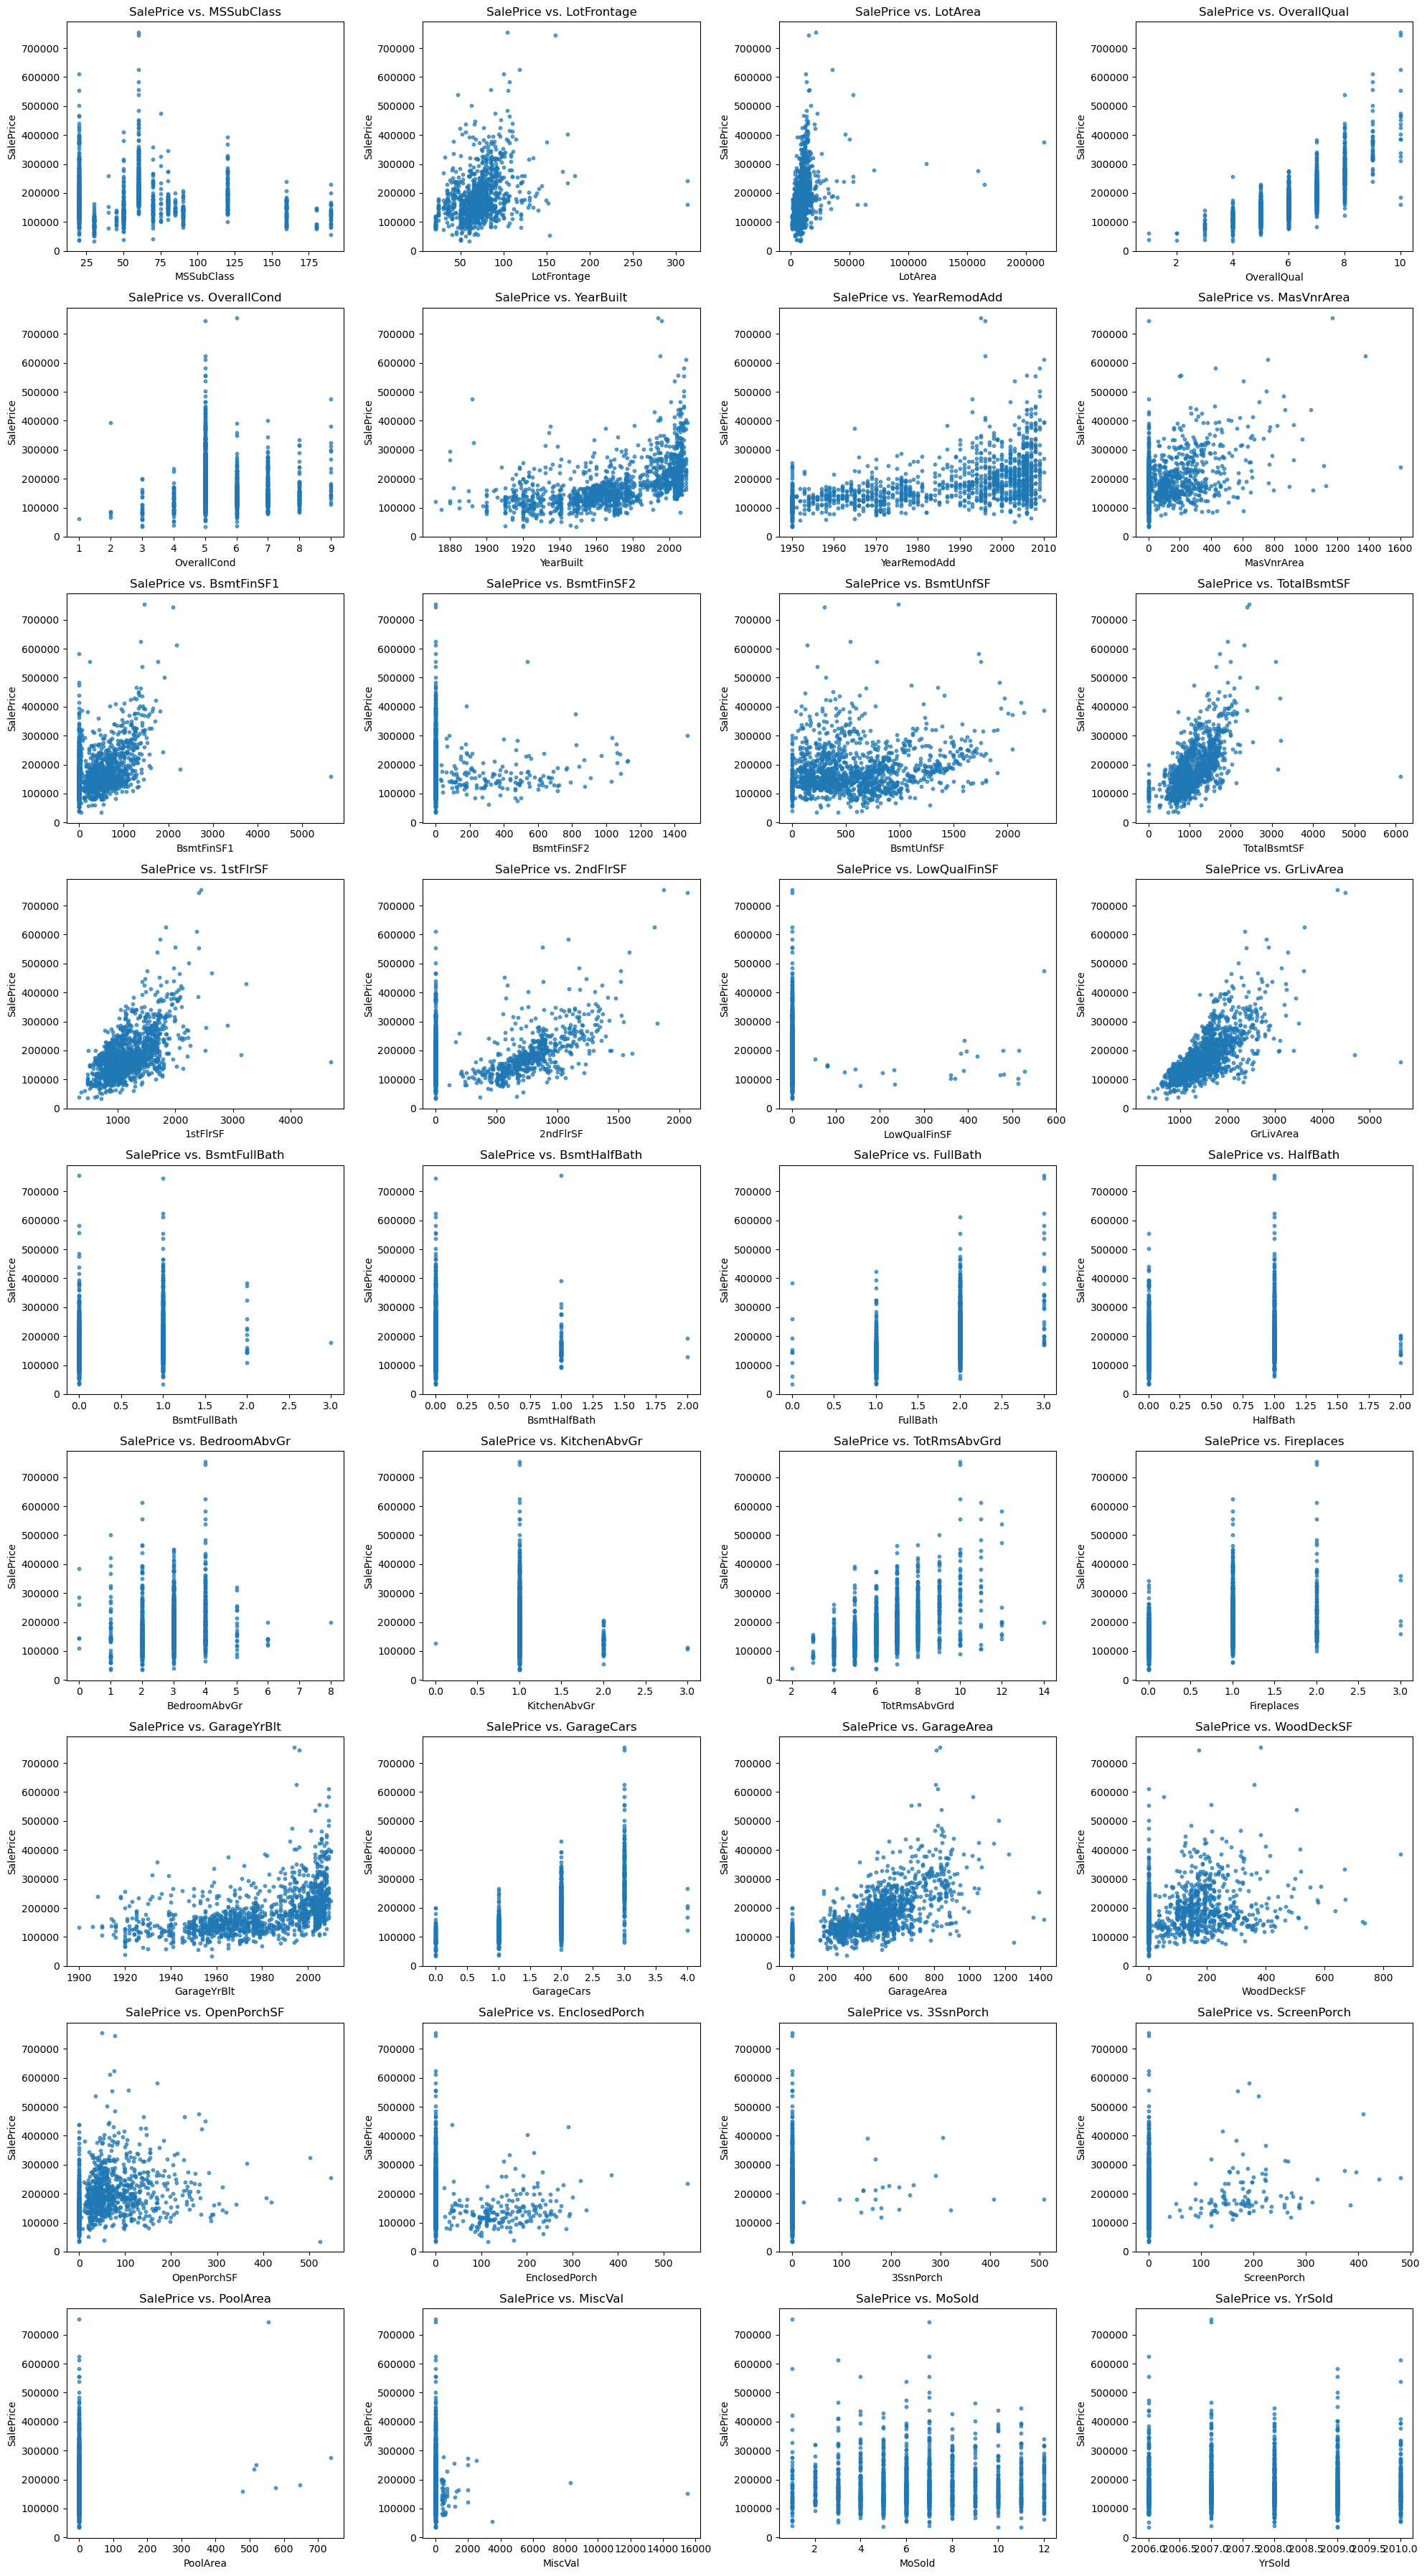

In [26]:
plot_label_vs_features(df_labels, df_feat_nums, cols_per_row=4)

In [27]:
# Remove less relevant numerical features
df_feat_nums = filter_numerical_by_label_corr(df_labels, df_feat_nums, threshold=0.45)

print(df_feat_nums.shape)

Kept (|corr| ≥ 0.45): ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea']
Dropped (|corr| < 0.45): ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
(1460, 13)


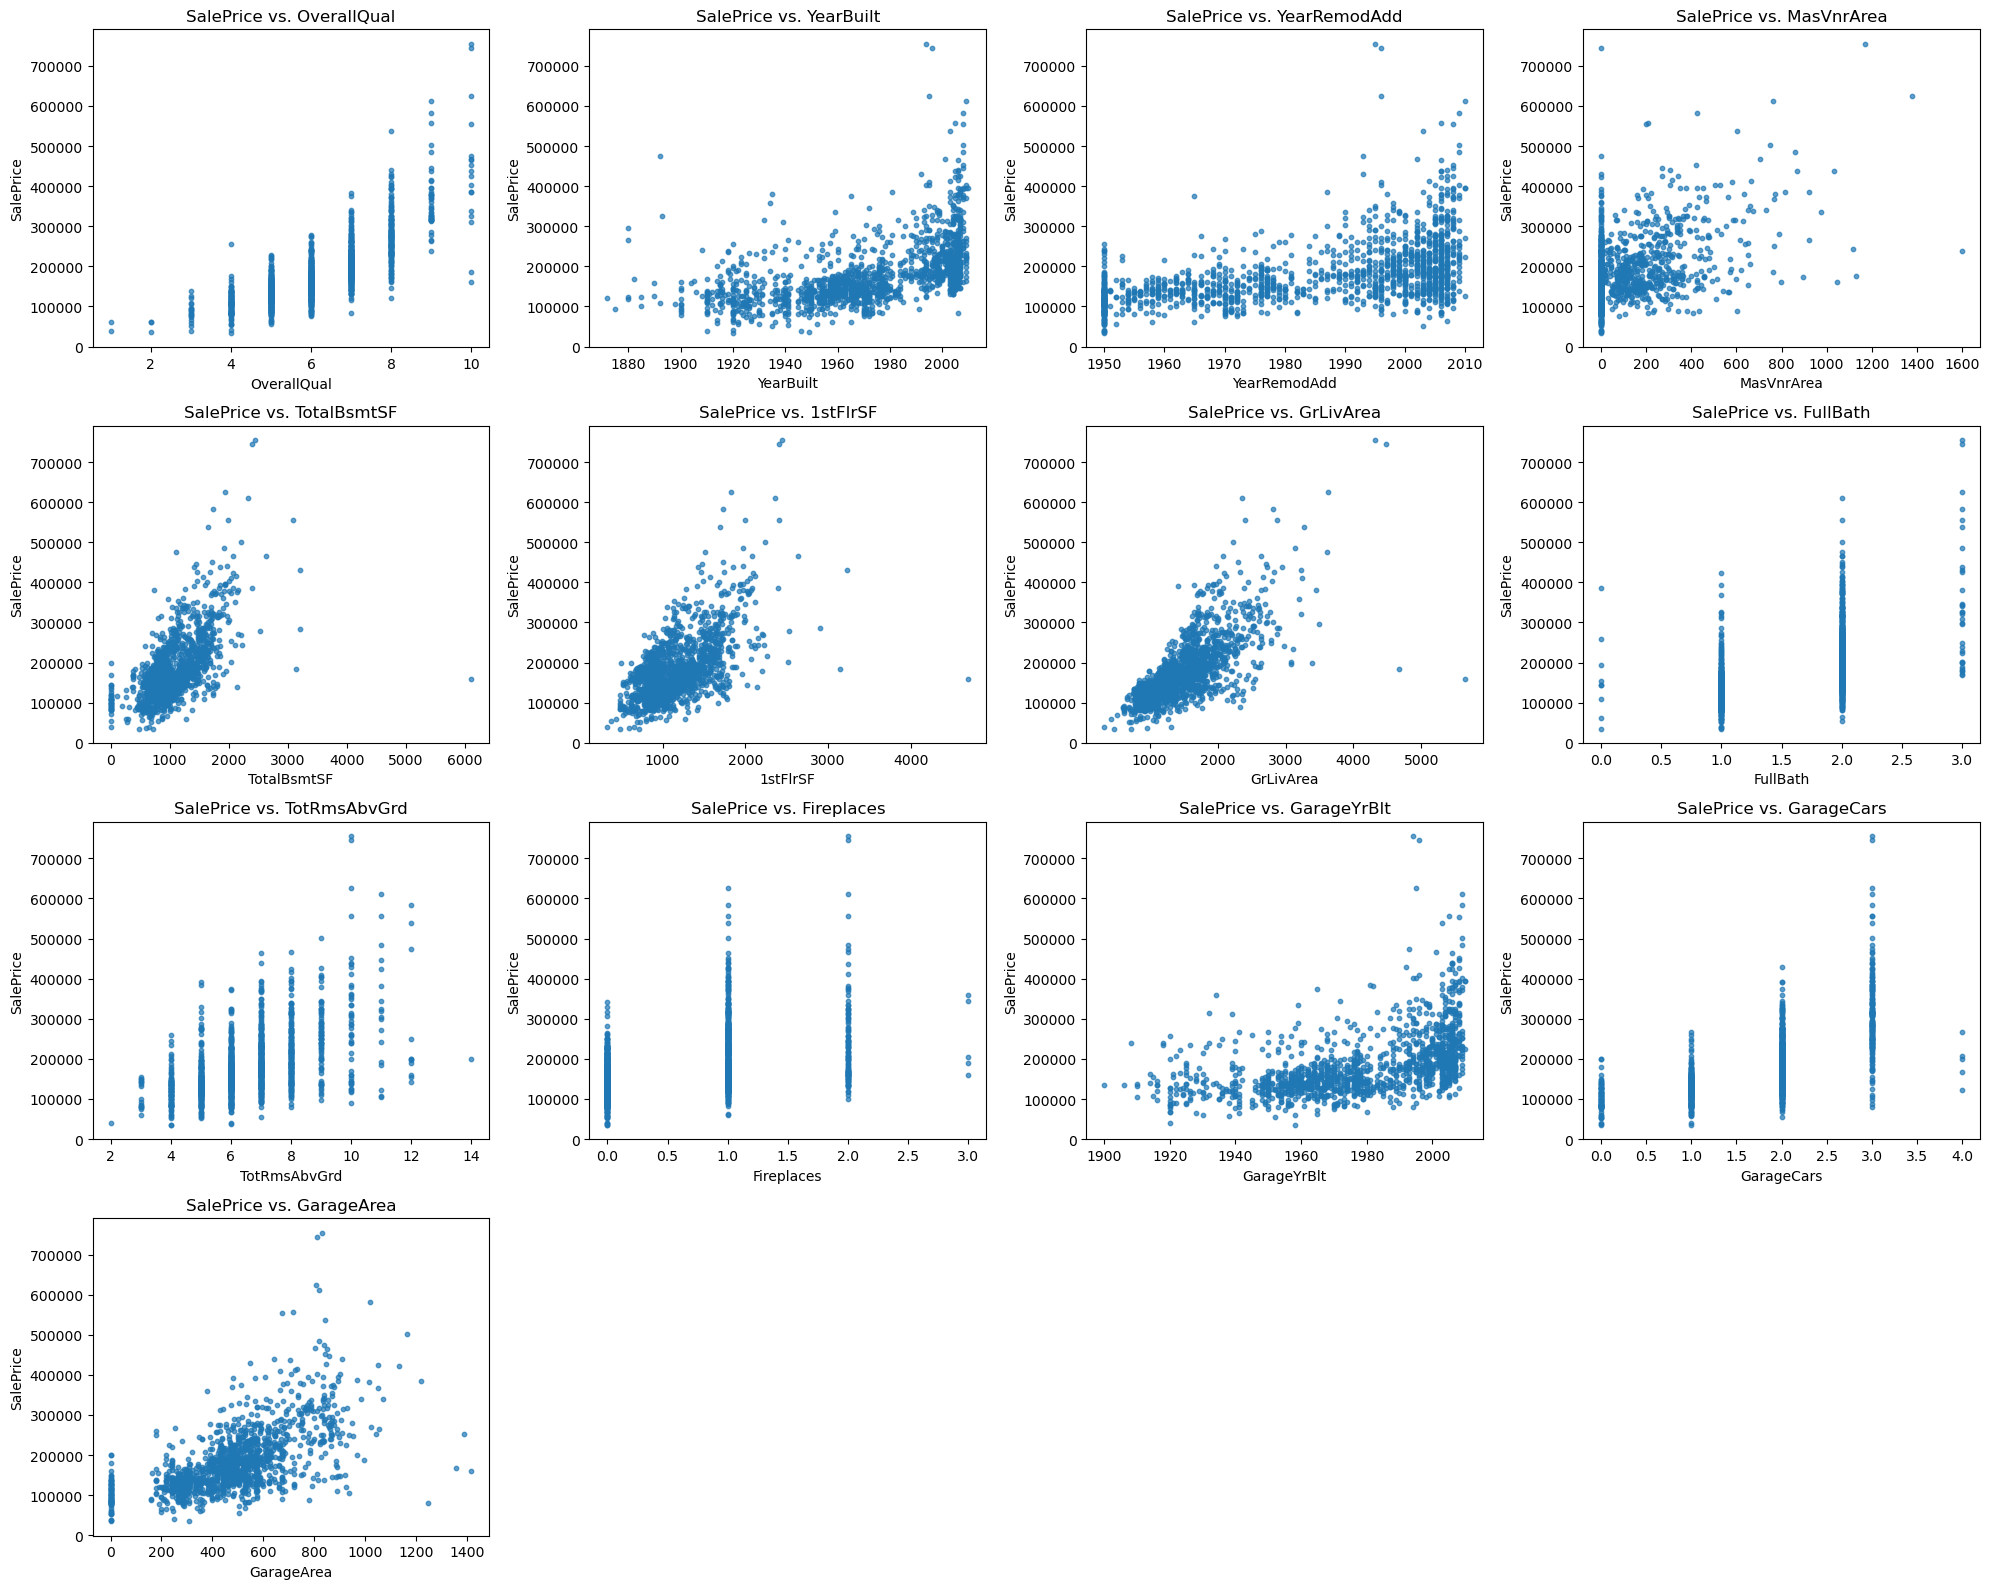

In [28]:
plot_label_vs_features(df_labels, df_feat_nums, cols_per_row=4)

In [29]:
df_feats = pd.concat([df_feat_cats, df_feat_nums], axis=1)

# Split training & validation data (80% training, 20% validation)
df_feat_trains, df_feat_vals, df_label_trains, df_label_vals = train_test_split(
    df_feats, df_labels, test_size=0.20, random_state=42
)

## 3. Model: XGBoost

XGBoost is a powerful and efficient gradient boosting library that excels in predictive modeling. It's known for its speed, accuracy, and scalability, making it a popular choice for both classification and regression tasks.

### Prepare training data

In [30]:
# 1. Make raw copies so we don’t mutate originals
xgb_X_train_raw = df_feat_trains.copy()
xgb_X_val_raw   = df_feat_vals.copy()

# 2. Replace infinities with NaN (XGBoost can handle NaN, but OneHotEncoder and median imputer need finite values)
xgb_X_train_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
xgb_X_val_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Identify which columns are numeric vs. categorical
xgb_num_cols = xgb_X_train_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()
xgb_cat_cols = xgb_X_train_raw.select_dtypes(include=["object", "category"]).columns.tolist()

# 4. Build separate pipelines for numeric and categorical processing
#    - Numeric: median imputation → standard scaling (scaling helps optimization, though not strictly required by XGBoost)
#    - Categorical: most_frequent imputation → one-hot encoding (ignore unknowns in validation)
numeric_pipeline = Pipeline([
    ("impute_num", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("impute_cat", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# 5. Combine them in a ColumnTransformer
xgb_preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, xgb_num_cols),
    ("cat", categorical_pipeline, xgb_cat_cols)
], remainder="drop")  # drop any other columns (should be none)

# 6. Fit on training data and transform both train & validation
xgb_X_train_arr = xgb_preprocessor.fit_transform(xgb_X_train_raw)
xgb_X_val_arr   = xgb_preprocessor.transform(xgb_X_val_raw)

# 7. Retrieve the feature names in the correct order
#    - Numeric names stay as-is
#    - OneHotEncoder produces names like "column_value"
xgb_num_feature_names = xgb_num_cols
xgb_cat_feature_names = (
    xgb_preprocessor
    .named_transformers_["cat"]
    .named_steps["onehot"]
    .get_feature_names_out(xgb_cat_cols)
    .tolist()
)

xgb_feature_names = xgb_num_feature_names + xgb_cat_feature_names

# 8. Build the final DataFrames for XGBoost
xgb_features_train = pd.DataFrame(
    xgb_X_train_arr,
    index=xgb_X_train_raw.index,
    columns=xgb_feature_names
)

xgb_features_val = pd.DataFrame(
    xgb_X_val_arr,
    index=xgb_X_val_raw.index,
    columns=xgb_feature_names
)

# 9. Copy labels (as a 1D Series) – XGBoost will accept a Series directly
xgb_labels_train = df_label_trains.iloc[:, 0].copy()
xgb_labels_val   = df_label_vals.iloc[:, 0].copy()

### Hyperparameters Tuning

In [31]:
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(
    lambda trial: xgb_objective(
        trial,
        xgb_features_train,
        xgb_labels_train,
        xgb_features_val,
        xgb_labels_val
    ),
    n_trials=50
)

# Print best parameters and best value
print("Best trial:")
print(f"  Validation RMSE: {xgb_study.best_value:.4f}")
print("  Best hyperparameters:")
for key, val in xgb_study.best_params.items():
    print(f"    {key}: {val}")

# Retrain a final model on the full training set using best_params
xgb_best_params = xgb_study.best_params.copy()
xgb_best_params.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42,
})

[I 2025-06-06 23:49:43,876] A new study created in memory with name: no-name-b7842c12-f708-4965-85cb-2f512b6b62d6
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-06 23:49:45,585] Trial 0 finished with value: 28257.804083064904 and parameters: {'learning_rate': 0.030375467237182114, 'max_depth': 6, 'subsample': 0.7124266966299279, 'colsample_bytree': 0.9111960902946452, 'reg_alpha': 1.9582623818134044e-05, 'reg_lambda': 0.01361166253773271, 'min_child_weight': 7, 'gamma': 0.8408583873361458}. Best is trial 0 with value: 28257.804083064904.
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean

Best trial:
  Validation RMSE: 24973.9926
  Best hyperparameters:
    learning_rate: 0.022346852671456193
    max_depth: 5
    subsample: 0.7433910646540848
    colsample_bytree: 0.9048558832808866
    reg_alpha: 2.4147762431252665e-06
    reg_lambda: 7.108320553066093e-08
    min_child_weight: 2
    gamma: 2.134286523142471


### Train the model using best hyperparameters

In [32]:
xgb_dtrain = xgb.DMatrix(xgb_features_train, label=xgb_labels_train, enable_categorical=True)
xgb_dval = xgb.DMatrix(xgb_features_val, label=xgb_labels_val, enable_categorical=True)
xgb_evals_result = {}
xgb_bst = xgb.train(
    xgb_best_params,
    xgb_dtrain,
    num_boost_round=1000,
    evals=[(xgb_dtrain, "train"), (xgb_dval, "validation")],
    evals_result=xgb_evals_result,
    early_stopping_rounds=50,
    verbose_eval=False,
)

# Calculate the accuracy %
xgb_val_preds = xgb_bst.predict(xgb_dval)
xgb_val_rmse = mean_squared_error(xgb_labels_val, xgb_val_preds, squared=False)
xgb_mape = mean_absolute_percentage_error(xgb_labels_val, xgb_val_preds)
xgb_accuracy_pct = (1.0 - xgb_mape) * 100.0
print(f"[Final model] RMSE: {xgb_val_rmse:.4f}")
print(f"[Final model] Validation accuracy: {xgb_accuracy_pct:.2f}%")

[Final model] RMSE: 24973.9926
[Final model] Validation accuracy: 90.01%


E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Visualization

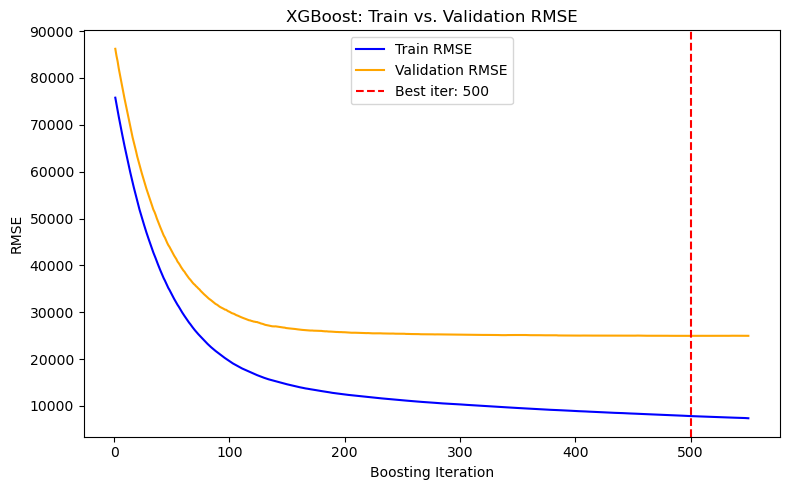

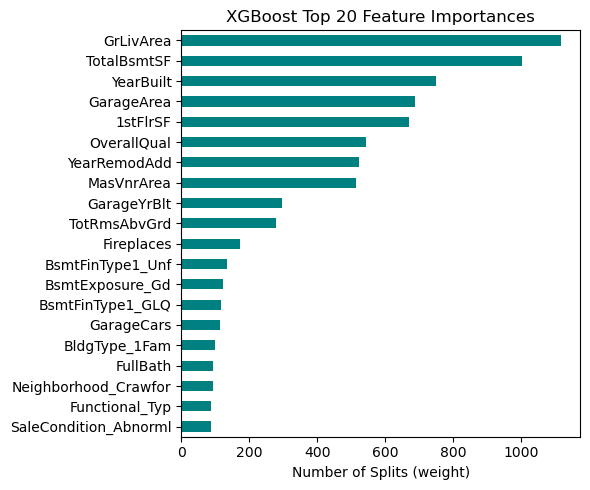

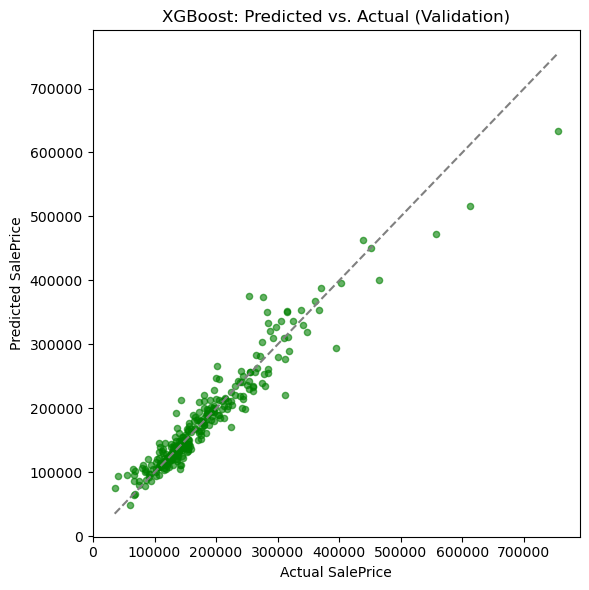

In [33]:
# a) Plot training vs. validation RMSE over iterations
xgb_train_rmse        = xgb_evals_result["train"]["rmse"]
xgb_val_rmse_history  = xgb_evals_result["validation"]["rmse"]
xgb_iterations        = list(range(1, len(xgb_train_rmse) + 1))

plt.figure(figsize=(8, 5))
plt.plot(xgb_iterations, xgb_train_rmse,       label="Train RMSE",      color="blue")
plt.plot(xgb_iterations, xgb_val_rmse_history, label="Validation RMSE", color="orange")
plt.axvline(
    xgb_bst.best_iteration + 1,
    color="red",
    linestyle="--",
    label=f"Best iter: {xgb_bst.best_iteration+1}"
)
plt.xlabel("Boosting Iteration")
plt.ylabel("RMSE")
plt.title("XGBoost: Train vs. Validation RMSE")
plt.legend()
plt.tight_layout()
plt.show()

# b) Feature Importance (top 20 by split count = 'weight')
xgb_importance_dict = xgb_bst.get_score(importance_type="weight")
xgb_imp_df = (
    pd.DataFrame.from_dict(xgb_importance_dict, orient="index", columns=["weight"])
      .sort_values("weight", ascending=False)
      .head(20)
)
plt.figure(figsize=(6, 5))
xgb_imp_df["weight"].plot(kind="barh", color="teal")
plt.gca().invert_yaxis()
plt.xlabel("Number of Splits (weight)")
plt.title("XGBoost Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# c) Predicted vs. Actual scatter (validation)
xgb_true_vals = df_label_vals.squeeze()  # if df_label_vals is a one-column DataFrame, this makes it a Series
plt.figure(figsize=(6, 6))
plt.scatter(xgb_true_vals, xgb_val_preds, alpha=0.6, s=20, color="green")
lims = [
    min(xgb_true_vals.min(), xgb_val_preds.min()),
    max(xgb_true_vals.max(), xgb_val_preds.max())
]
plt.plot(lims, lims, linestyle="--", color="gray")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("XGBoost: Predicted vs. Actual (Validation)")
plt.tight_layout()
plt.show()

## 4. Model: Random Forest

A random forest is a supervised machine learning algorithm that uses an ensemble of decision trees to make predictions. It's a powerful and versatile tool used for both classification and regression tasks.

### Training data preparation

In [34]:
# 1a. Make copies of the raw DataFrames
rf_X_train_raw = df_feat_trains.copy()
rf_X_val_raw   = df_feat_vals.copy()

# 1b. Replace infinities with NaN
rf_X_train_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
rf_X_val_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

# 1c. Identify numerical vs. categorical columns
rf_num_cols = rf_X_train_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()
rf_cat_cols = rf_X_train_raw.select_dtypes(include=["object", "category"]).columns.tolist()

# 1d. Build separate imputers/encoders for numeric and categorical
rf_numeric_imputer = SimpleImputer(strategy="mean")
rf_categorical_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

rf_preprocessor = ColumnTransformer([
    ("num", rf_numeric_imputer, rf_num_cols),
    ("cat", rf_categorical_pipeline, rf_cat_cols)
], remainder="drop")

# 1e. Fit on training data, then transform both train and val
rf_X_train_arr = rf_preprocessor.fit_transform(rf_X_train_raw)
rf_X_val_arr   = rf_preprocessor.transform(rf_X_val_raw)

# 1f. Get combined feature names directly:
rf_all_names = rf_preprocessor.get_feature_names_out()

rf_X_train = pd.DataFrame(
    rf_X_train_arr,
    index=rf_X_train_raw.index,
    columns=rf_all_names
)

rf_X_val = pd.DataFrame(
    rf_X_val_arr,
    index=rf_X_val_raw.index,
    columns=rf_all_names  # ensure same column order
)

# 1g. Handle labels (replace inf/NaN if necessary)
rf_y_train = (df_label_trains
              .iloc[:, 0]                        # grab the single column as a Series
              .replace([np.inf, -np.inf], np.nan)
              .fillna(df_label_trains.median().iloc[0])
              .copy()
             )

rf_y_val = (df_label_vals
            .iloc[:, 0]
            .replace([np.inf, -np.inf], np.nan)
            .fillna(df_label_trains.median().iloc[0])
            .copy()
           )

### Hyperparameters Tuning

In [35]:
rf_study = optuna.create_study(direction="minimize")
rf_study.optimize(
    lambda trial: rf_objective(trial, rf_X_train, rf_y_train, rf_X_val, rf_y_val),
    n_trials=50
)

print("Best hyperparameters found:")
for key, val in rf_study.best_params.items():
    print(f"  {key}: {val}")

[I 2025-06-06 23:51:22,947] A new study created in memory with name: no-name-8586a435-8116-4bce-8a41-ee3ebe7279f9
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-06 23:51:23,136] Trial 0 finished with value: 37474.42965928197 and parameters: {'n_estimators': 134, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 37474.42965928197.
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-06 23:51:23,569] Trial 1 finished with value: 37590.446408562595 and parameters: {'n_estimators': 23

Best hyperparameters found:
  n_estimators: 96
  max_depth: 8
  min_samples_split: 8
  min_samples_leaf: 2
  max_features: None


### Model training

In [36]:
rf_best_params = rf_study.best_params.copy()
# Ensure reproducibility and parallelism
rf_best_params.update({
    "random_state": 42,
    "n_jobs": -1
})

rf_model = RandomForestRegressor(**rf_best_params)
rf_model.fit(rf_X_train, rf_y_train)

rf_val_preds   = rf_model.predict(rf_X_val)
rf_mse         = mean_squared_error(rf_y_val, rf_val_preds, squared=True)    # Mean Squared Error
rf_rmse        = mean_squared_error(rf_y_val, rf_val_preds, squared=False)   # Root MSE
rf_mape        = mean_absolute_percentage_error(rf_y_val, rf_val_preds)
rf_accuracy_pct = (1.0 - rf_mape) * 100.0

print(f"[Random Forest] Validation MSE:  {rf_mse:.4f}")
print(f"[Random Forest] Validation RMSE: {rf_rmse:.4f}")
print(f"[Random Forest] Validation MAPE: {rf_mape:.4f}")
print(f"[Random Forest] Validation Accuracy (100 - MAPE): {rf_accuracy_pct:.2f}%")

[Random Forest] Validation MSE:  918345772.7280
[Random Forest] Validation RMSE: 30304.2204
[Random Forest] Validation MAPE: 0.1159
[Random Forest] Validation Accuracy (100 - MAPE): 88.41%


E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Visualization

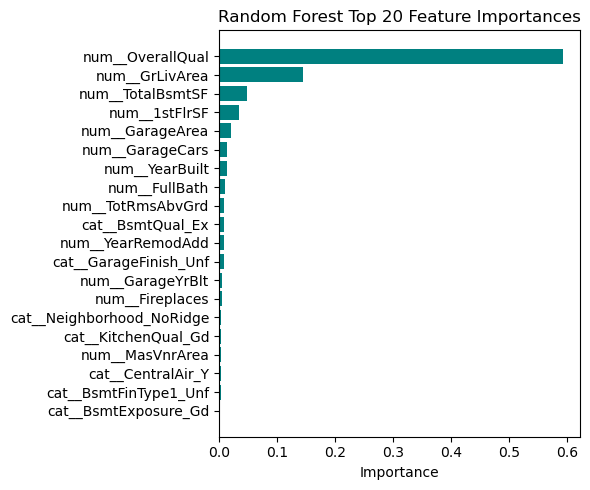

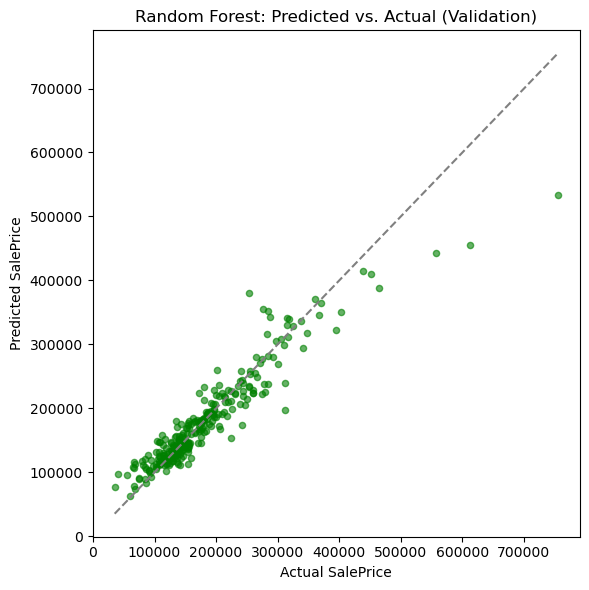

In [37]:
# a) Feature importance (top 20)
importances = rf_model.feature_importances_
rf_imp_df = (
    pd.DataFrame({
        "feature": rf_X_train.columns,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .head(20)
)

plt.figure(figsize=(6, 5))
plt.barh(rf_imp_df["feature"][::-1], rf_imp_df["importance"][::-1], color="teal")
plt.xlabel("Importance")
plt.title("Random Forest Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# b) Predicted vs Actual scatter (validation)
plt.figure(figsize=(6, 6))
plt.scatter(rf_y_val.values, rf_val_preds, alpha=0.6, s=20, color="green")
lims = [
    min(rf_y_val.min(), rf_val_preds.min()),
    max(rf_y_val.max(), rf_val_preds.max())
]
plt.plot(lims, lims, linestyle="--", color="gray")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Random Forest: Predicted vs. Actual (Validation)")
plt.tight_layout()
plt.show()

## 5. Model: CatBoost

CatBoost is an open-source software library developed by Yandex. It provides a gradient boosting framework which, among other features, attempts to solve for categorical features using a permutation-driven alternative to the classical algorithm.

### Data preparation

In [38]:
# 1. Make copies so we don’t mutate originals
cb_X_train_raw = df_feat_trains.copy()
cb_X_val_raw   = df_feat_vals.copy()

# 2. Replace infinities with NaN (numbers only) — can leave categorical NaN for now
cb_X_train_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
cb_X_val_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Identify categorical columns
cb_cat_cols = cb_X_train_raw.select_dtypes(include=["object", "category"]).columns.tolist()

# 4. Fill NaN in categorical columns with a placeholder string BEFORE casting to category
for col in cb_cat_cols:
    # Fill missing values with "missing" (or any string not already used)
    cb_X_train_raw[col] = cb_X_train_raw[col].fillna("missing").astype("category")
    cb_X_val_raw[col]   = cb_X_val_raw[col].fillna("missing").astype("category")

# 5. Now handle labels as before (numeric labels can still have NaN/infinity imputed, etc.)
cb_y_train = (
    df_label_trains
    .iloc[:, 0]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(df_label_trains.iloc[:, 0].median())
    .copy()
)
cb_y_val = (
    df_label_vals
    .iloc[:, 0]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(df_label_trains.iloc[:, 0].median())
    .copy()
)

# 6. Build CatBoost Pools
cb_train_pool = Pool(data=cb_X_train_raw, label=cb_y_train, cat_features=cb_cat_cols)
cb_val_pool   = Pool(data=cb_X_val_raw,   label=cb_y_val,   cat_features=cb_cat_cols)

### Hyperparameters Tuning

In [39]:
cb_study = optuna.create_study(direction="minimize")
cb_study.optimize(
    lambda trial: cb_objective(trial, cb_train_pool, cb_val_pool),
    n_trials=50
)

print("Best CatBoost params:")
for key, val in cb_study.best_params.items():
    print(f"  {key}: {val}")

[I 2025-06-06 23:51:46,883] A new study created in memory with name: no-name-c18a70e2-679d-4618-9f03-febf60cdc079
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-06 23:52:55,454] Trial 0 finished with value: 29477.12304560052 and parameters: {'iterations': 553, 'learning_rate': 0.06910356319061577, 'depth': 9, 'l2_leaf_reg': 0.11212156590332716}. Best is trial 0 with value: 29477.12304560052.
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-06 23:53:01,343] Trial 1 finished with value: 46324.60543364388 and parameters: {'iterations': 179, 'lea

Best CatBoost params:
  iterations: 302
  learning_rate: 0.12779413606167608
  depth: 5
  l2_leaf_reg: 0.7901183121196428


### Model Training

In [40]:
cb_best_params = cb_study.best_params.copy()
cb_best_params.update({
    "random_seed": 42,
    "verbose": 0
})

cb_model = CatBoostRegressor(**cb_best_params)
cb_model.fit(
    cb_train_pool,
    eval_set=cb_val_pool,
    early_stopping_rounds=50,
    use_best_model=True
)

cb_val_preds = cb_model.predict(cb_val_pool)
cb_rmse = mean_squared_error(cb_y_val, cb_val_preds, squared=False)
cb_mape = mean_absolute_percentage_error(cb_y_val, cb_val_preds)
cb_accuracy_pct = (1.0 - cb_mape) * 100.0

print(f"[CatBoost] Validation RMSE: {cb_rmse:.4f}")
print(f"[CatBoost] Validation MAPE: {cb_mape:.4f}")
print(f"[CatBoost] Validation Accuracy (100 - MAPE): {cb_accuracy_pct:.2f}%")

[CatBoost] Validation RMSE: 26325.7432
[CatBoost] Validation MAPE: 0.1057
[CatBoost] Validation Accuracy (100 - MAPE): 89.43%


E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Visualization

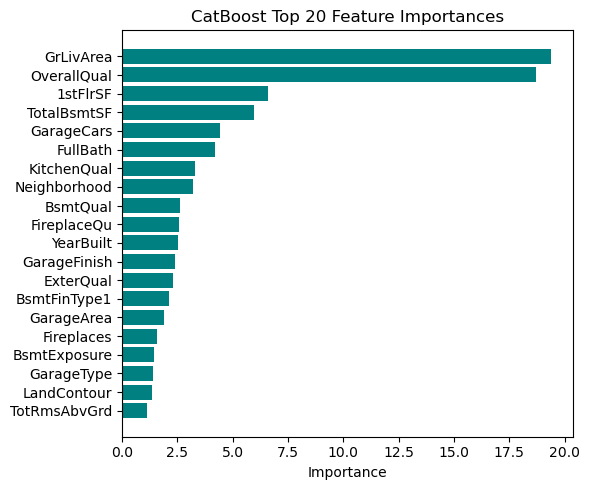

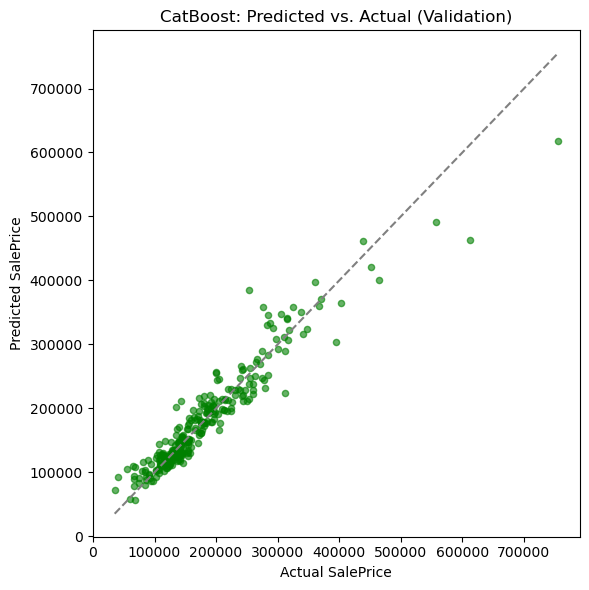

In [41]:
# a) Feature importance (top 20)
cb_feature_importances = cb_model.get_feature_importance(type="FeatureImportance")
cb_feat_names = cb_model.feature_names_
cb_imp_df = (
    pd.DataFrame({
        "feature": cb_feat_names,
        "importance": cb_feature_importances
    })
    .sort_values("importance", ascending=False)
    .head(20)
)

plt.figure(figsize=(6, 5))
plt.barh(cb_imp_df["feature"][::-1], cb_imp_df["importance"][::-1], color="teal")
plt.xlabel("Importance")
plt.title("CatBoost Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# b) Predicted vs Actual scatter (validation)
plt.figure(figsize=(6, 6))
plt.scatter(cb_y_val.values, cb_val_preds, alpha=0.6, s=20, color="green")
lims = [
    min(cb_y_val.min(), cb_val_preds.min()),
    max(cb_y_val.max(), cb_val_preds.max())
]
plt.plot(lims, lims, linestyle="--", color="gray")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("CatBoost: Predicted vs. Actual (Validation)")
plt.tight_layout()
plt.show()

## 6. Model: ElasticNet

### Data preparation

In [42]:
# 1a. Make copies of the raw feature DataFrames so we do not mutate originals
en_X_train_raw = df_feat_trains.copy()   # :contentReference[oaicite:1]{index=1}
en_X_val_raw   = df_feat_vals.copy()     # :contentReference[oaicite:2]{index=2}

# 1b. Replace infinities with NaN (CatBoost would handle NaN automatically, but ElasticNet needs explicit handling) :contentReference[oaicite:3]{index=3}
en_X_train_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
en_X_val_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

# 1c. Identify numerical vs. categorical columns
en_num_cols = en_X_train_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()      # :contentReference[oaicite:4]{index=4}
en_cat_cols = en_X_train_raw.select_dtypes(include=["object", "category"]).columns.tolist()    # :contentReference[oaicite:5]{index=5}

# 1d. Build pipelines for numeric and categorical preprocessing:
#     - Numeric: median imputation → standard scaling (ElasticNet benefits from standardized features) :contentReference[oaicite:6]{index=6}
#     - Categorical: most_frequent imputation → one-hot encoding (drop first to avoid multicollinearity) :contentReference[oaicite:7]{index=7}
en_numeric_pipeline = Pipeline([
    ("impute_num", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

en_categorical_pipeline = Pipeline([
    ("impute_cat", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first"))
])

# 1e. Combine them in a ColumnTransformer
en_preprocessor = ColumnTransformer([
    ("num", en_numeric_pipeline, en_num_cols),
    ("cat", en_categorical_pipeline, en_cat_cols)
], remainder="drop")  # drop any other columns not specified

# 1f. Fit/transform as before
en_X_train_arr = en_preprocessor.fit_transform(en_X_train_raw)
en_X_val_arr   = en_preprocessor.transform(en_X_val_raw)

# 1g. Obtain all output feature names in one shot
en_feature_names = en_preprocessor.get_feature_names_out()

# 1h. Build DataFrames
en_X_train = pd.DataFrame(en_X_train_arr, index=en_X_train_raw.index, columns=en_feature_names)
en_X_val   = pd.DataFrame(en_X_val_arr,   index=en_X_val_raw.index,   columns=en_feature_names)

# 1i. Handle labels: replace inf/NaN if necessary, then convert to a 1D array for training :contentReference[oaicite:12]{index=12}
en_y_train = (
    df_label_trains
    .iloc[:, 0]  # if it’s a one-column DataFrame, convert to Series
    .replace([np.inf, -np.inf], np.nan)
    .fillna(df_label_trains.iloc[:, 0].median())
    .copy()
)

en_y_val = (
    df_label_vals
    .iloc[:, 0]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(df_label_trains.iloc[:, 0].median())
    .copy()
)

E:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [14, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Hyperparameters Tuning

In [43]:
# Create and run study (minimize RMSE) :contentReference[oaicite:20]{index=20}
en_study = optuna.create_study(direction="minimize")
en_study.optimize(
    lambda t: en_objective(t, en_X_train.values, en_y_train.values, en_X_val.values, en_y_val.values),
    n_trials=50
)

print("Best hyperparameters for ElasticNet:")
for key, val in en_study.best_params.items():
    print(f"  {key}: {val}")

[I 2025-06-07 00:04:05,411] A new study created in memory with name: no-name-63a92613-f240-48d5-a6dd-77d49bb5f569
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-07 00:04:05,427] Trial 0 finished with value: 31685.16318412344 and parameters: {'alpha': 0.015167905107381354, 'l1_ratio': 0.11291199391766904}. Best is trial 0 with value: 31685.16318412344.
E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-07 00:04:05,858] Trial 1 finished with value: 39100.38025163195 and parameters: {'alpha': 0.0005443655801752203, 'l1_ratio': 0.9634000395712969}.

Best hyperparameters for ElasticNet:
  alpha: 0.00934131548632225
  l1_ratio: 0.2835622693197045


### Model Training

In [44]:
# Retrieve best params and enforce reproducibility
en_best_params = en_study.best_params.copy()
en_best_params.update({
    "fit_intercept": True,
    "max_iter": 10_000,
    "random_state": 42
})

# Instantiate the final model
en_model = ElasticNet(**en_best_params)

# Fit on the preprocessed training data
en_model.fit(en_X_train.values, en_y_train.values)

# Predict on validation
en_val_preds = en_model.predict(en_X_val.values)

# Compute RMSE and MAPE
en_val_rmse = mean_squared_error(en_y_val.values, en_val_preds, squared=False)
en_val_mape = mean_absolute_percentage_error(en_y_val.values, en_val_preds)
en_val_accuracy_pct = (1.0 - en_val_mape) * 100.0

print(f"[ElasticNet] Validation RMSE: {en_val_rmse:.4f}")
print(f"[ElasticNet] Validation MAPE: {en_val_mape:.4f}")
print(f"[ElasticNet] Validation Accuracy (100 - MAPE): {en_val_accuracy_pct:.2f}%")

[ElasticNet] Validation RMSE: 31489.8629
[ElasticNet] Validation MAPE: 0.1251
[ElasticNet] Validation Accuracy (100 - MAPE): 87.49%


E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Visualization

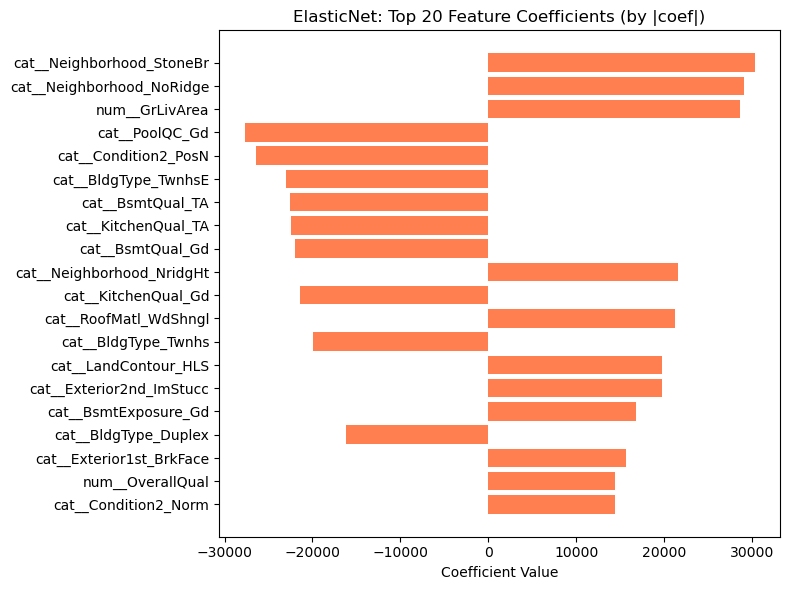

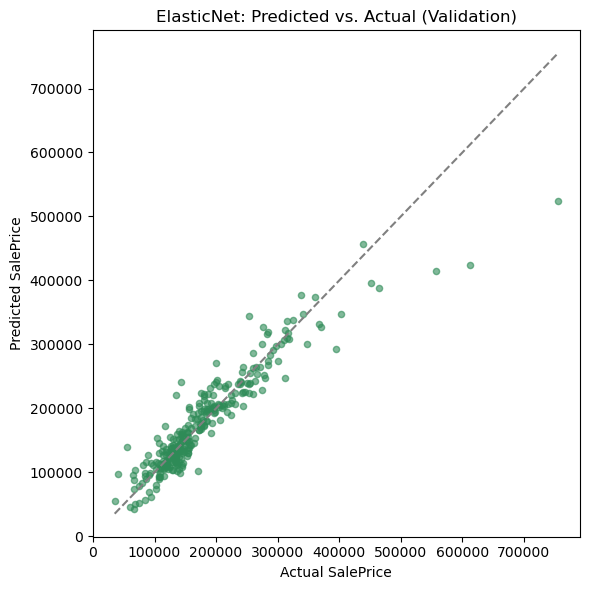

In [45]:
# Coefficient magnitude plot (Top 20 in absolute value)
en_coef = en_model.coef_
en_coef_df = pd.DataFrame({
    "feature": en_feature_names,
    "coefficient": en_coef
})
en_coef_df["abs_coef"] = en_coef_df["coefficient"].abs()
en_coef_top20 = en_coef_df.sort_values("abs_coef", ascending=False).head(20)

plt.figure(figsize=(8, 6))
plt.barh(
    en_coef_top20["feature"][::-1],
    en_coef_top20["coefficient"][::-1],
    color="coral"
)
plt.xlabel("Coefficient Value")
plt.title("ElasticNet: Top 20 Feature Coefficients (by |coef|)")
plt.tight_layout()
plt.show()

# Predicted vs Actual scatter (validation)
plt.figure(figsize=(6, 6))
plt.scatter(en_y_val.values, en_val_preds, alpha=0.6, s=20, color="seagreen")
lims = [
    min(en_y_val.min(), en_val_preds.min()),
    max(en_y_val.max(), en_val_preds.max())
]
plt.plot(lims, lims, linestyle="--", color="gray")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("ElasticNet: Predicted vs. Actual (Validation)")
plt.tight_layout()
plt.show()

## 7. Model: Ensemble

Ensemble top 3 models with best accuracy

### Prepare data

In [46]:
# 1a. Make copies of the raw DataFrames
ensemble_X_train_raw = df_feat_trains.copy()
ensemble_X_val_raw   = df_feat_vals.copy()

# 1b. Replace infinities with NaN
ensemble_X_train_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
ensemble_X_val_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

# 1c. Identify numerical vs. categorical columns
ensemble_num_cols = ensemble_X_train_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()
ensemble_cat_cols = ensemble_X_train_raw.select_dtypes(include=["object", "category"]).columns.tolist()

# 1d. Build separate imputers/encoders for numeric and categorical
ensemble_numeric_imputer = SimpleImputer(strategy="mean")
ensemble_categorical_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

ensemble_preprocessor = ColumnTransformer([
    ("num", ensemble_numeric_imputer, ensemble_num_cols),
    ("cat", ensemble_categorical_pipeline, ensemble_cat_cols)
], remainder="drop")

# 1e. Fit on training data, then transform both train and val
ensemble_X_train_arr = ensemble_preprocessor.fit_transform(ensemble_X_train_raw)
ensemble_X_val_arr   = ensemble_preprocessor.transform(ensemble_X_val_raw)

# 1f. Get combined feature names directly:
ensemble_all_names = ensemble_preprocessor.get_feature_names_out()

ensemble_X_train = pd.DataFrame(
    ensemble_X_train_arr,
    index=ensemble_X_train_raw.index,
    columns=ensemble_all_names
)

ensemble_X_val = pd.DataFrame(
    ensemble_X_val_arr,
    index=ensemble_X_val_raw.index,
    columns=ensemble_all_names  # ensure same column order
)

# 1g. Handle labels (replace inf/NaN if necessary)
ensemble_y_train = (df_label_trains
              .iloc[:, 0]                        # grab the single column as a Series
              .replace([np.inf, -np.inf], np.nan)
              .fillna(df_label_trains.median().iloc[0])
              .copy()
             )

ensemble_y_val = (df_label_vals
            .iloc[:, 0]
            .replace([np.inf, -np.inf], np.nan)
            .fillna(df_label_trains.median().iloc[0])
            .copy()
           )

print("ensemble_X_train_raw.shape: ", ensemble_X_train_raw.shape)
print("ensemble_X_val_raw.shape: ", ensemble_X_val_raw.shape)
print("ensemble_X_val.shape: ", ensemble_X_val.shape)

ensemble_X_train_raw.shape:  (1168, 56)
ensemble_X_val_raw.shape:  (292, 56)
ensemble_X_val.shape:  (292, 262)


### Find top-3 performing models

In [47]:
# 1. Put the non-ensemble models into a dictionary mapping model names to accuracy
accuracy_dict = {
    "ElasticNet": en_val_accuracy_pct,
    "CatBoost": cb_accuracy_pct,
    "RandomForest": rf_accuracy_pct,
    "XGBoost": xgb_accuracy_pct
}

# 2. Sort models by accuracy from highest to lowest
sorted_models = sorted(accuracy_dict.items(), key=lambda item: item[1], reverse=True)

# 3. Print in order
print("Models ranked by accuracy (best → worst):")
for model_name, acc in sorted_models:
    print(f"  {model_name}: {acc:.2f}%")

Models ranked by accuracy (best → worst):
  XGBoost: 90.01%
  CatBoost: 89.43%
  RandomForest: 88.41%
  ElasticNet: 87.49%


### Model training

In [48]:
ensemble_xgb = XGBRegressor(
    **xgb_best_params,
    n_estimators=xgb_bst.best_iteration + 1,  # use the same number of trees
    random_state=42,
    tree_method="hist",
)

ensemble_xgb.fit(ensemble_X_train, ensemble_y_train)

ensemble_voting = VotingRegressor([
    ("rf", rf_model),
    ("cb",      cb_model),
    ("xgb",     ensemble_xgb)
])

ensemble_voting.fit(ensemble_X_train, ensemble_y_train)

ensemble_val_preds = ensemble_voting.predict(ensemble_X_val)

ensemble_val_rmse = mean_squared_error(ensemble_y_val, ensemble_val_preds, squared=False)
ensemble_val_mape = mean_absolute_percentage_error(ensemble_y_val, ensemble_val_preds)
ensemble_val_accuracy_pct = (1.0 - ensemble_val_mape) * 100.0

print(f"[Ensemble] Validation RMSE: {ensemble_val_rmse:.4f}")
print(f"[Ensemble] Validation MAPE: {ensemble_val_mape:.4f}")
print(f"[Ensemble] Validation Accuracy (100 - MAPE): {ensemble_val_accuracy_pct:.2f}%")

[Ensemble] Validation RMSE: 26978.3384
[Ensemble] Validation MAPE: 0.1020
[Ensemble] Validation Accuracy (100 - MAPE): 89.80%


E:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Visuals

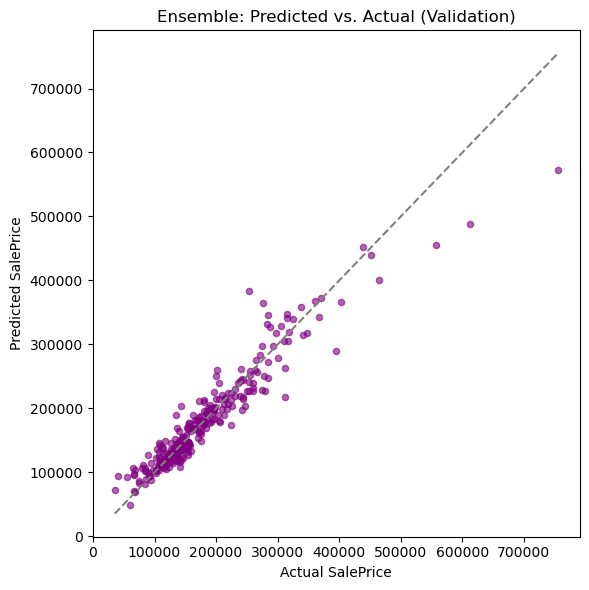

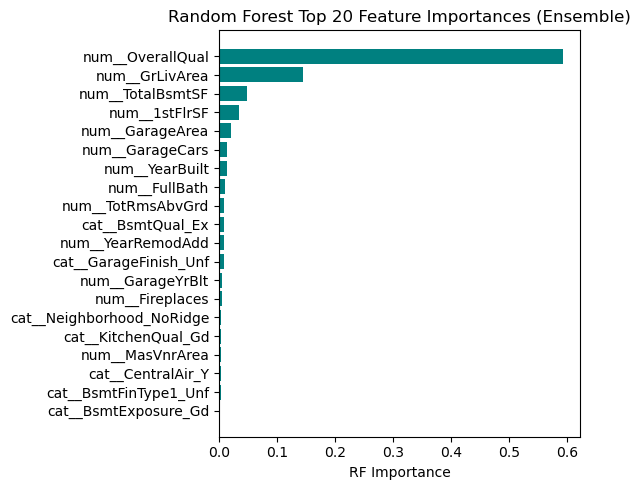

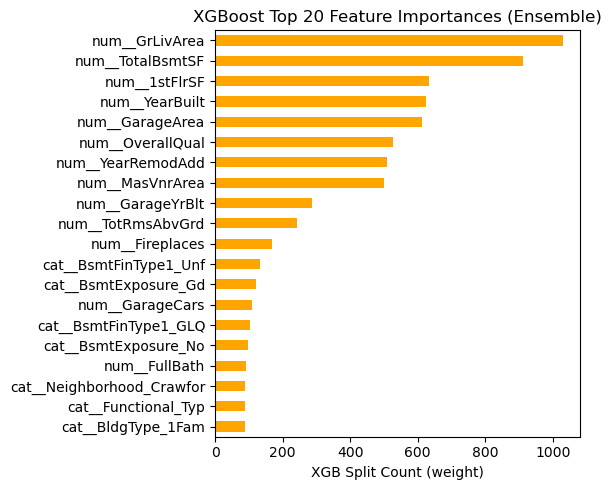

In [49]:
# a) Predicted vs. Actual scatter (validation) for the ensemble
plt.figure(figsize=(6, 6))
plt.scatter(ensemble_y_val.values, ensemble_val_preds, alpha=0.6, s=20, color="purple")
lims = [
    min(ensemble_y_val.min(), ensemble_val_preds.min()),
    max(ensemble_y_val.max(), ensemble_val_preds.max())
]
plt.plot(lims, lims, linestyle="--", color="gray")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Ensemble: Predicted vs. Actual (Validation)")
plt.tight_layout()
plt.show()

# b) Feature importances from the Random Forest and XGBoost components
#    (CatBoost has its own importance, but here we display RF and XGB side by side)

# RF importances (top 20)
rf_importances = rf_model.feature_importances_
rf_imp_df = (
    pd.DataFrame({
        "feature": ensemble_all_names,
        "importance": rf_importances
    })
    .sort_values("importance", ascending=False)
    .head(20)
)

plt.figure(figsize=(6, 5))
plt.barh(rf_imp_df["feature"][::-1], rf_imp_df["importance"][::-1], color="teal")
plt.xlabel("RF Importance")
plt.title("Random Forest Top 20 Feature Importances (Ensemble)")
plt.tight_layout()
plt.show()

# XGB importances (top 20 by weight)
xgb_importance_dict = ensemble_xgb.get_booster().get_score(importance_type="weight")
xgb_imp_df = (
    pd.DataFrame.from_dict(xgb_importance_dict, orient="index", columns=["weight"])
      .sort_values("weight", ascending=False)
      .head(20)
)

plt.figure(figsize=(6, 5))
xgb_imp_df["weight"].plot(kind="barh", color="orange")
plt.gca().invert_yaxis()
plt.xlabel("XGB Split Count (weight)")
plt.title("XGBoost Top 20 Feature Importances (Ensemble)")
plt.tight_layout()
plt.show()

## 8. Conclusion

In [50]:
# 1. Put them into a dictionary mapping model names to accuracy
accuracy_dict = {
    "Ensemble": ensemble_val_accuracy_pct,
    "ElasticNet": en_val_accuracy_pct,
    "CatBoost": cb_accuracy_pct,
    "RandomForest": rf_accuracy_pct,
    "XGBoost": xgb_accuracy_pct
}

# 2. Find the model with the highest accuracy
best_model = max(accuracy_dict, key=accuracy_dict.get)
best_accuracy = accuracy_dict[best_model]

# 3. Print the result
print(f"Best model: {best_model} with accuracy {best_accuracy:.2f}%")

Best model: XGBoost with accuracy 90.01%


## 9. Submit the Competition

Using the model with best accuracy so far

In [51]:
# 1. Load test.csv and split off Id
t_df = pd.read_csv("E:/Reva-M-Tech/MTech-AI-Projects/house-prices-advanced-regression-techniques/test.csv")
t_ids = t_df["Id"]
t_X_raw = t_df.drop("Id", axis=1)

# 2. Replace infinities with NaN (consistent with training preprocessing)
t_X_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Identify categorical columns for CatBoost (as during training)
t_cat_cols = t_X_raw.select_dtypes(include=["object", "category"]).columns.tolist()

# 4. Fill NaN in categorical columns for CatBoost and cast to category dtype
t_X_cb = t_X_raw.copy()
for col in t_cat_cols:
    t_X_cb[col] = t_X_cb[col].fillna("missing").astype("category")

# 5. Prepare test features for each model:
# 5a. ElasticNet & RandomForest & Ensemble use ensemble_preprocessor (one-hot + impute)
t_X_en_arr = ensemble_preprocessor.transform(t_X_raw)
t_X_en = pd.DataFrame(
    t_X_en_arr,
    index=t_X_raw.index,
    columns=ensemble_all_names
)

# 5b. RandomForest and Ensemble use the same as ensemble_preprocessor
t_X_rf = t_X_en.copy()

# 5c. XGBoost uses xgb_preprocessor (its own numeric+one-hot pipeline)
t_X_xgb_arr = xgb_preprocessor.transform(t_X_raw)
dtest_xgb = xgb.DMatrix(t_X_xgb_arr, feature_names=xgb_feature_names)

# 5d. CatBoost Pool
dtest_cb = Pool(data=t_X_cb, cat_features=t_cat_cols)

# 6. Determine best model (must match previously computed accuracies)
accuracy_dict = {
    "Ensemble": ensemble_val_accuracy_pct,
    "ElasticNet": en_val_accuracy_pct,
    "CatBoost": cb_accuracy_pct,
    "RandomForest": rf_accuracy_pct,
    "XGBoost": xgb_accuracy_pct
}
best_model = max(accuracy_dict, key=accuracy_dict.get)

# 7. Predict with the best model
if best_model == "ElasticNet":
    test_preds = en_model.predict(t_X_en.values)

elif best_model == "RandomForest":
    test_preds = rf_model.predict(t_X_rf.values)

elif best_model == "XGBoost":
    test_preds = xgb_bst.predict(dtest_xgb, iteration_range=(0, xgb_bst.best_iteration))

elif best_model == "CatBoost":
    test_preds = cb_model.predict(dtest_cb)

elif best_model == "Ensemble":
    # Ensemble expects the same preprocessing as RandomForest/ElasticNet
    test_preds = ensemble_voting.predict(t_X_en)

else:
    raise ValueError(f"Unknown best_model: {best_model}")

# 8. Build submission DataFrame and save
submission_df = pd.DataFrame({"Id": t_ids, "SalePrice": test_preds})
submission_df.to_csv("submission.csv", index=False)

## 10. Roadmap

Potential improvements for future iteration:
1.  Feed all features into the models and compare the result with the current approach.
2.  Attempt to selectively remove the features based on each model's feature importance